##  Outlier Detection Part II: DBSCAN

This is the second post in a series that deals with Anomaly detection, or more specifically: Outlier detection. Anomaly detection means finding data points that are somehow different from the bulk of the data (Outlier detection), or different from previously seen data (Novelty detection). The aim of this series is to explore which algorithms have which advantages and disadvantages for outlier detection tasks. 

After addressing MAD in a previous post, in this post we will look at the DBSCAN algorithm: a clustering algorithm that also identifies outliers. 


#### DBSCAN

DBSCAN is a density-based clustering approach, and not an outlier detection method per-se. It grows clusters based on a distance measure. Core points -points that have a minimum of points in their surrounding- and points that are close enough to those core points together form a cluster. 

We can use DBSCAN as an outlier detection algorithm becuase points that do not belong to any cluster get their own class: -1. The algorithm has two parameters (epsilon: length scale, and min_samples: the minimum number of samples required for a point to be a core point). Finding a good epsilon is critical. 

DBSCAN thus makes binary predictions: a point is either an outlier or not. To refine the predictions, we consider the other clusters apart from the main cluster also as outlier clusters, the smaller the cluster, the higher the outlier score. 

The used distance function will be the default Euclidean distance. Note that the worst-case performance of DBSCAN is O(n^2), if the neighbourhood scan is a linear scan, which is the case for the sci-kit learn implementation. This significantly limits the dataset size that can be analyzed. 

One can also pass a distance matrix instead of a matrix of datapoints to the algorithm, which should reduce the time complexity. A speed-up was however not observed, but a significant memory-load (despite the matrix being sparse), so this is not done. 


### Metrics

As discussed in part I, both the AUC and the Average precision are considered. 


In [1]:
# Standard library imports
from collections import Counter, defaultdict
import time
import os

# Third party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (auc, average_precision_score, 
                              roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.base import BaseEstimator

plt.rcParams.update({'font.size': 12})

# Misc. imports
from blogutils import plot_metrics_curves, memotodisk


In [2]:
import sklearn; print(sklearn.__version__)


0.20.2


In [3]:
def labels_from_DBclusters(db):
    """
    Returns labels for each point for "outlierness", based on DBSCAN results.
    The higher the score, the more likely the point is an outlier, based on its cluster membership
    
    - dbscan label -1 (outliers): highest score of 1
    - largest cluster gets score 0  
    - points belonging to clusters get a score that is higher when the cluster size is smaller
    
    db: a fitted DBscan instance
    Returns: labels (similar to "y_predicted", but the values merely reflect a ranking)
    """
    labels = np.zeros(len(db.labels_))
    
    # make a list of tuples: (i, num points in i) for i in db.labels_
    label_counts = [(i, np.sum(db.labels_==i)) for i in set(db.labels_) - set([-1])]
    label_counts.sort(key=lambda x : -x[1]) # sort by counts per class, descending
    
    # assign the labels. Those points with label =-1 get highest label (equal to number of classes -1) 
    labels[db.labels_== -1] = len(set(db.labels_)) - 1
    for i, (label, label_count) in enumerate(label_counts):
        labels[db.labels_==label] = i
        
    # Scale the values between 0 and 1
    labels = (labels - min(labels)) / (max(labels) - min(labels))
    return(labels)   

We will use the memoizer described [here](https://donernesto.github.io/blog/memoization-for-machine-learning/) to automatically save and load previously calculated results


In [4]:
@memotodisk    
def dbscan_outlier_pred(X, epsilon=0.3, min_samples=10, **kwargs):
    db = DBSCAN(eps=epsilon, min_samples=min_samples, **kwargs)
    db.fit(X)
    return labels_from_DBclusters(db)


## 1. Credit card dataset

See https://donernesto.github.io/blog/outlier-detection-data-preparation
for details on this and other datasets


In [5]:
with open(r"data/anomaly_credit.dat","rb") as f:
    X_downsampled2_credit = np.load(f)
    y_downsampled2_credit = np.load(f)   
    X_downsampled_credit = np.load(f)
    y_downsampled_credit = np.load(f)
    X_credit = np.load(f)
    y_credit = np.load(f)
print('Total number of points downsampled2:{}. Number of positives: {} (fraction: {:.2%})'.format(
            len(y_downsampled2_credit), y_downsampled2_credit.sum(), y_downsampled2_credit.mean()))
print('Total number of points downsampled: {}. Number of positives: {} (fraction: {:.2%})'.format(
            len(y_downsampled_credit), y_downsampled_credit.sum(), y_downsampled_credit.mean()))
print('Total number of points full: {}. Number of positives: {} (fraction: {:.2%})'.format(
            len(y_credit), y_credit.sum(), y_credit.mean()))

Total number of points downsampled2:3093. Number of positives: 98 (fraction: 3.17%)
Total number of points downsampled: 28530. Number of positives: 98 (fraction: 0.34%)
Total number of points full: 284807. Number of positives: 492 (fraction: 0.17%)


#### Example: single prediction

This looks promising: the positives are present mainly in the smaller classes and outlier class (by fraction).  Let us visualize the results. 

In [6]:
db = DBSCAN(eps=5, min_samples=10).fit(X_downsampled2_credit)
for i in set(db.labels_):
    print('class {}: number of points {:d}, number of positives {} (fraction: {:.3%})'.format(
        i,  np.sum(db.labels_==i), y_downsampled2_credit[db.labels_==i].sum(), 
        y_downsampled2_credit[db.labels_==i].mean()))

class 0: number of points 2766, number of positives 11 (fraction: 0.398%)
class 1: number of points 15, number of positives 0 (fraction: 0.000%)
class -1: number of points 312, number of positives 87 (fraction: 27.885%)


In [7]:
print('Total number of point: {}. Number of positives: {} (fraction: {:.2%})'.format(
            len(y_downsampled2_credit), y_downsampled2_credit.sum(), y_downsampled2_credit.mean()))

Total number of point: 3093. Number of positives: 98 (fraction: 3.17%)


class 0: number of points 2766, fraction of positives 0.398%
class 1: number of points 15, fraction of positives 0.000%
class -1: number of points 312, fraction of positives 27.885%


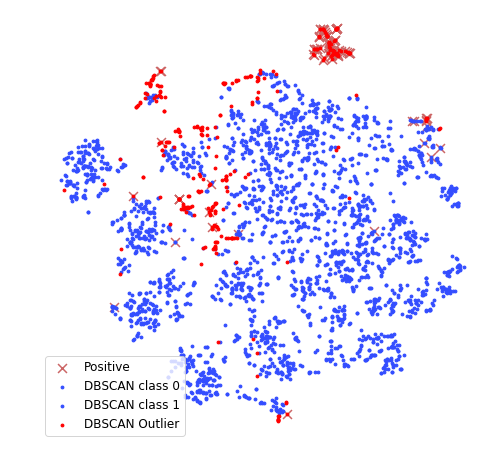

In [8]:
MAX_N_TSNE = 3500 #Avoid overly long computation times with TSNE. Values < 5000 recommended 
neg = y_downsampled2_credit == 0
pos = y_downsampled2_credit == 1
assert len(X_downsampled2_credit) <= MAX_N_TSNE, 'Using a dataset with more than {} points is not recommended'.format(
                                            MAX_N_TSNE)
X_2D = TSNE(n_components=2, perplexity=30, n_iter=400).fit_transform(X_downsampled2_credit) # collapse in 2-D space for plotting
for i in set(db.labels_):
    print('class {}: number of points {:d}, fraction of positives {:.3%}'.format(i, 
                                                                np.sum(db.labels_==i),
                                                                y_downsampled2_credit[db.labels_==i].mean()))
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_2D[pos, 0], X_2D[pos, 1], c=[[0.8, 0.4, 0.4],], marker='x', s=80, label='Positive')

for i in set(db.labels_):
    if i == -1: 
        #outlier according to dbscan
        ax.scatter(X_2D[db.labels_==i, 0], X_2D[db.labels_==i, 1], c='r', s=8, label='DBSCAN Outlier')
    else:
        ax.scatter(X_2D[db.labels_==i, 0], X_2D[db.labels_==i, 1], s=8, c=[[0.2, 0.3, max(i*0.2 + 0.4, 1)],],
                                                                           label='DBSCAN class {}'.format(i))
plt.axis('off')
plt.legend()
plt.show()                                                                                 

Note how the outliers are indeed removed from the main cluster, and how the "outlier cluster" is correctly marked as a DBSCAN outlier class of -1. TSNE brings them altogether, altough they -according to DBSCAN- do not form a single cluster (the "-1" points don't belong anywhere). The actual outliers (crosses) are typically well-identified. 

Next, apply DBSCAN on a larger fraction of the dataset, find optimal parameters and look at its performance. 

#### Parameter scan


In [9]:
# Run this for various min_samples and epsilon
def dbscan_scan(X, y, min_samples_list=(5, 10), epsilon_list=(1, 2, 5, 10), random_state=None):
    """ A scan function for DBSCAN. Iterates over min_samples_list and epsilon_list
    random_state (None or int) : if int, this will be set as a random seed and data will be shuffled
    """
    dbscan_dict = defaultdict(list)
    if random_state:
        np.random.seed(random_state)
        idx = np.random.choice(len(y), len(y), replace=False)
        X = X[idx, :]
        y = y[idx]

    for min_samples in min_samples_list:
        for epsilon in epsilon_list:            
            print('calculating result for epsilon {}, min_samples {}...'.format(
            epsilon, min_samples))
            
            # dbscan_outlier_pred returns 1 for the outlier class, and 0 for the main "inlier" class
            y_predicted = dbscan_outlier_pred(X, epsilon=epsilon, min_samples=min_samples) 
            auc_db = roc_auc_score(y_true=y, y_score=y_predicted)
            pr_db = average_precision_score(y_true=y, y_score=y_predicted)
            num_clusters = len(set(y_predicted))
            precision_outlier_class = y[y_predicted == 1].mean()
            size_outlier_cluster = np.sum(y_predicted == 1)

            # store results in a DataFrame
            
            for k, v in (('epsilon', epsilon), ('min_samples', min_samples), ('AUC', auc_db), 
                         ('num_clusters', num_clusters), ('size_outlier_cluster', size_outlier_cluster), 
                         ('AP', pr_db), ('precision_outlier_class', precision_outlier_class),
                         ('random_state', random_state)):
                dbscan_dict[k].append(v)
        dbscan_results_df = pd.DataFrame.from_dict(dbscan_dict)

    return dbscan_results_df

In [10]:
print('Total number of points downsampled:{}. Number of positives: {} (fraction: {:.2%})'.format(
            len(y_downsampled_credit), y_downsampled_credit.sum(), y_downsampled_credit.mean()))

Total number of points downsampled:28530. Number of positives: 98 (fraction: 0.34%)


In [11]:
dbscan_results_df = dbscan_scan(X_downsampled_credit, y_downsampled_credit, 
                               epsilon_list=10*np.array([0.3, 0.4, 0.6, 0.8, 1.0, 2.0, 5.0]))

calculating result for epsilon 3.0, min_samples 5...
calculating result for epsilon 4.0, min_samples 5...
calculating result for epsilon 6.0, min_samples 5...
calculating result for epsilon 8.0, min_samples 5...
calculating result for epsilon 10.0, min_samples 5...
calculating result for epsilon 20.0, min_samples 5...
calculating result for epsilon 50.0, min_samples 5...
calculating result for epsilon 3.0, min_samples 10...
calculating result for epsilon 4.0, min_samples 10...
calculating result for epsilon 6.0, min_samples 10...
calculating result for epsilon 8.0, min_samples 10...
calculating result for epsilon 10.0, min_samples 10...
calculating result for epsilon 20.0, min_samples 10...
calculating result for epsilon 50.0, min_samples 10...


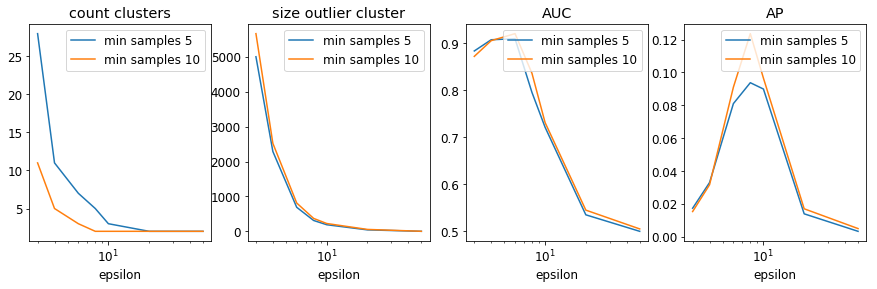

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
for min_samples in [5, 10]:
    for y_, axs_idx, title_ in zip(('AUC', 'num_clusters', 'size_outlier_cluster', 'AP'),
                                   (2, 0, 1, 3),
                                   ('AUC', 'count clusters', 'size outlier cluster', 'AP')):
        dbscan_results_df.loc[dbscan_results_df.min_samples==min_samples].plot(
            x='epsilon', y=y_, ax=axs[axs_idx], label='min samples {}'.format(min_samples))
        axs[axs_idx].set_title(title_)
        axs[axs_idx].semilogx()

plt.show()

In [13]:
# show numbers for 10 samples
dbscan_results_df.iloc[len(dbscan_results_df)//2:, :].astype('float').round(3)

,epsilon,min_samples,AUC,num_clusters,size_outlier_cluster,AP,precision_outlier_class,random_state
7,3.0,10.0,0.872,11.0,5654.0,0.015,0.016,NaN
8,4.0,10.0,0.906,5.0,2519.0,0.032,0.035,NaN
9,6.0,10.0,0.921,3.0,814.0,0.091,0.104,NaN
10,8.0,10.0,0.836,2.0,374.0,0.124,0.179,NaN
11,10.0,10.0,0.731,2.0,228.0,0.097,0.202,NaN
12,20.0,10.0,0.545,2.0,59.0,0.017,0.153,NaN
13,50.0,10.0,0.505,2.0,6.0,0.005,0.167,NaN


Note the decreasing number of clusters for increasing epsilon: choosing epsilon larger means making the characteristic lengthscale larger, effectively bringing points closer together. A small epsilon, combined with a small required number of points to form a cluster (min_samples), results in many small clusters. 

Let's make a final prediction and visualize the results. 

In [14]:
y_predicted = dbscan_outlier_pred(X_downsampled_credit, min_samples=10, epsilon=8)


In [15]:
auc_db = roc_auc_score(y_true=y_downsampled_credit, y_score=y_predicted )
pr_db = average_precision_score(y_true=y_downsampled_credit, y_score=y_predicted )

In [16]:
print(auc_db, pr_db)

0.8364378883235906 0.1235628387670908


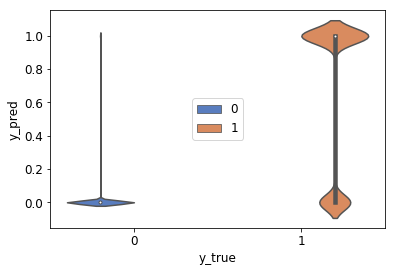

In [17]:
prediction_df = pd.DataFrame(index=range(len(y_downsampled_credit)))
prediction_df['y_true'] = y_downsampled_credit
prediction_df['y_pred'] = y_predicted
ax = sns.violinplot(y='y_pred', x="y_true", hue="y_true",
                   data=prediction_df, palette="muted",
                   bw=0.10);
ax.legend(loc=10)
plt.show();

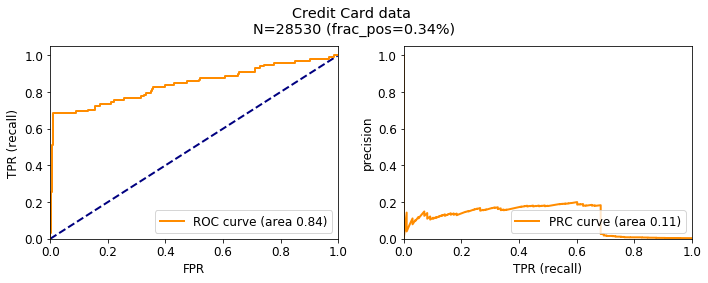

In [18]:
c = 0.01 
plot_metrics_curves(y_downsampled_credit, y_predicted + c * np.random.randn(len(y_predicted)), 
                    title='Credit Card data \n')
#Set c to 0 to see why jitter is needed for the PRC curve

## Conclusion

The DBSCAN algorithm is useful for clustering datasets, and is able to detect outliers in its outlier class. By design, it does not return outlier scores (but membership to classes, one of which an outlier class: points that do not belong to any cluster). The discrete nature of this classification seems to severely limit its average precision score. Choosing the right epsilon is essential. For the current dataset, a possible strategy seems to be to increase epsilon so much that there are only two classes: the inlier and outlier classes. This is not guaranteed to work in other situations, though. 

Its N^2 time complexity prevents it from being used on really large datasets. We therefore add the result for the Credit Card dataset to the table, and leave DBSCAN for what it is in the context of outlier detection. 

In [19]:
AUC_df = pd.read_pickle('AUC_partI.pkl') ; AP_df = pd.read_pickle('AP_partI.pkl')
AUC_df['DBSCAN'] = '' ; AP_df['DBSCAN'] = ''

In [20]:
AUC_df.loc['CreditCard', 'DBSCAN'] = '*{:.2f}'.format(auc_db)
AP_df.loc['CreditCard', 'DBSCAN'] = '*{:.2f}'.format(pr_db)

In [21]:
print('AUC:')
AUC_df

AUC:


,MAD,DBSCAN
CreditCard,0.95 (*0.95),*0.84
PaySim,0.75,
ForestCover,0.76,
MNIST_0/6,0.63,


In [22]:
print('Average precision:')
AP_df

Average precision:


,MAD,DBSCAN
CreditCard,0.47 (*0.75),*0.12
PaySim,0.16,
ForestCover,0.04,
MNIST_0/6,0.14,


\* Downsampled data

In [23]:
AUC_df.to_pickle('AUC_partII.pkl'); AP_df.to_pickle('AP_partII.pkl')